<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/PreparationDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation Dataset**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook นี้ใช้สำหรับการจัดเตรียมรูปภาพให้พร้อมก่อนที่จะนำภาพเข้าโมเดล CNN ซึ่งประกอบไปด้วย

1.   การโหลด Dataset จาก Kaggle
2.   การจัดเตรียม Directory สำหรับดึง Image ไปใช้งาน
3.   การแบ่งข้อมูล Training, Validation และ Testing โดยเก็บเป็น Index ในรูปแบบ .csv เพื่อใช้ซ้ำในครั้งถัดไป
4.   การ Visualization images เพื่อรายงานผลเบื้องต้นเกี่ยวกับ Dataset
5.   เสริมการแก้ Imbalanced Dataset ด้วยการ Augmentation

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**  

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com  
**EDA:** https://www.kaggle.com/code/abhishekgbhat/eda-cnn-architecture-tuning-80-83-accuracy#Univariate-EDA

## **Section 0: Import important library**

In [82]:
import pandas as pd
import numpy as np
import random as rd
import tensorflow as tf
import keras
import sklearn
import joblib

import kagglehub
import os
import shutil
import glob
from tqdm import tqdm
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import cv2
import scipy.stats as ss

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


## **Section 1: Preparing the directory for dataset**

### **In G-Drive Directory**

In [5]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
ASSETS_VISUALIZE_IMG_PATH = f"{ASSETS_PATH}/images" # Visualize Image Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000Dataset"
OVER_DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling"
INDEX_PATH = f"{DRIVE_DIR}/datasets/indexSetting"

In [6]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

### **In Runtime Directory**

In [7]:
KAGGLE_BASE_DIR = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", KAGGLE_BASE_DIR)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [8]:
METADATA_PATH = f"{KAGGLE_BASE_DIR}/HAM10000_metadata.csv"
IMAGE_PART_ONE = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_1"
IMAGE_PART_TWO = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_2"

In [9]:
IMAGE_PART_ONE_PATH = glob.glob(os.path.join(IMAGE_PART_ONE, "*.jpg"))
IMAGE_PART_TWO_PATH = glob.glob(os.path.join(IMAGE_PART_TWO, "*.jpg"))
MERGE_IMAGES = IMAGE_PART_ONE_PATH + IMAGE_PART_TWO_PATH

In [10]:
paths_dict = {os.path.basename(x).split(".")[0] : x for x in MERGE_IMAGES}
print(f"Number of dictionary elements: {len(paths_dict)}")

Number of dictionary elements: 10015


In [11]:
BASE_DATASET_DIR = "/content/ham10000Dataset"
OVER_DATASET_DIR = "/content/ham10000DatasetOversampling"

##**Section 2: Exploratory Data Analysis (EDA)**

### **Read metadata**

In [12]:
metadata = pd.read_csv(METADATA_PATH)
metadata

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

### **Mapping imagepath, full label and class index**

In [13]:
lesion_type_dict = {
    "akiec": "Actinic keratoses",
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "df": "Dermatofibroma",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
    "vasc": "Vascular lesions"
} # เพื่อให้ลำดับ Index เหมือนตอน Train โมเดล

lesion_type_mapping = {v: k for k, v in enumerate(lesion_type_dict.values())}

metadata["filepaths"] = metadata["image_id"].map(paths_dict.get)
metadata["cell_type"] = metadata["dx"].map(lesion_type_dict.get)
metadata["cell_type"] = pd.Categorical(
    metadata["cell_type"],
    categories=[lesion_type_dict[k] for k in lesion_type_dict.keys()],
    ordered=True
)
metadata["cell_type_idx"] = metadata["cell_type"].cat.codes

metadata

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                               filepaths  \
0      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                  ...   
10010  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10011  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10012  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10013  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10014  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[10015 rows x 10 columns]

### **Handle missing value for age column**

In [14]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {metadata.shape}")
print(f"Row of metadata: {metadata.shape[0]}")
print(f"Column of metadata: {metadata.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(metadata.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(metadata.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {metadata.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (10015, 10)
Row of metadata: 10015
Column of metadata: 10
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
filepaths         0
cell_type         0
cell_type_idx     0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id          object
image_id           object
dx                 object
dx_type            object
age               float64
sex                object
localization       object
filepaths          object
cell_type        category
cell_type_idx        int8
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


<Axes: >

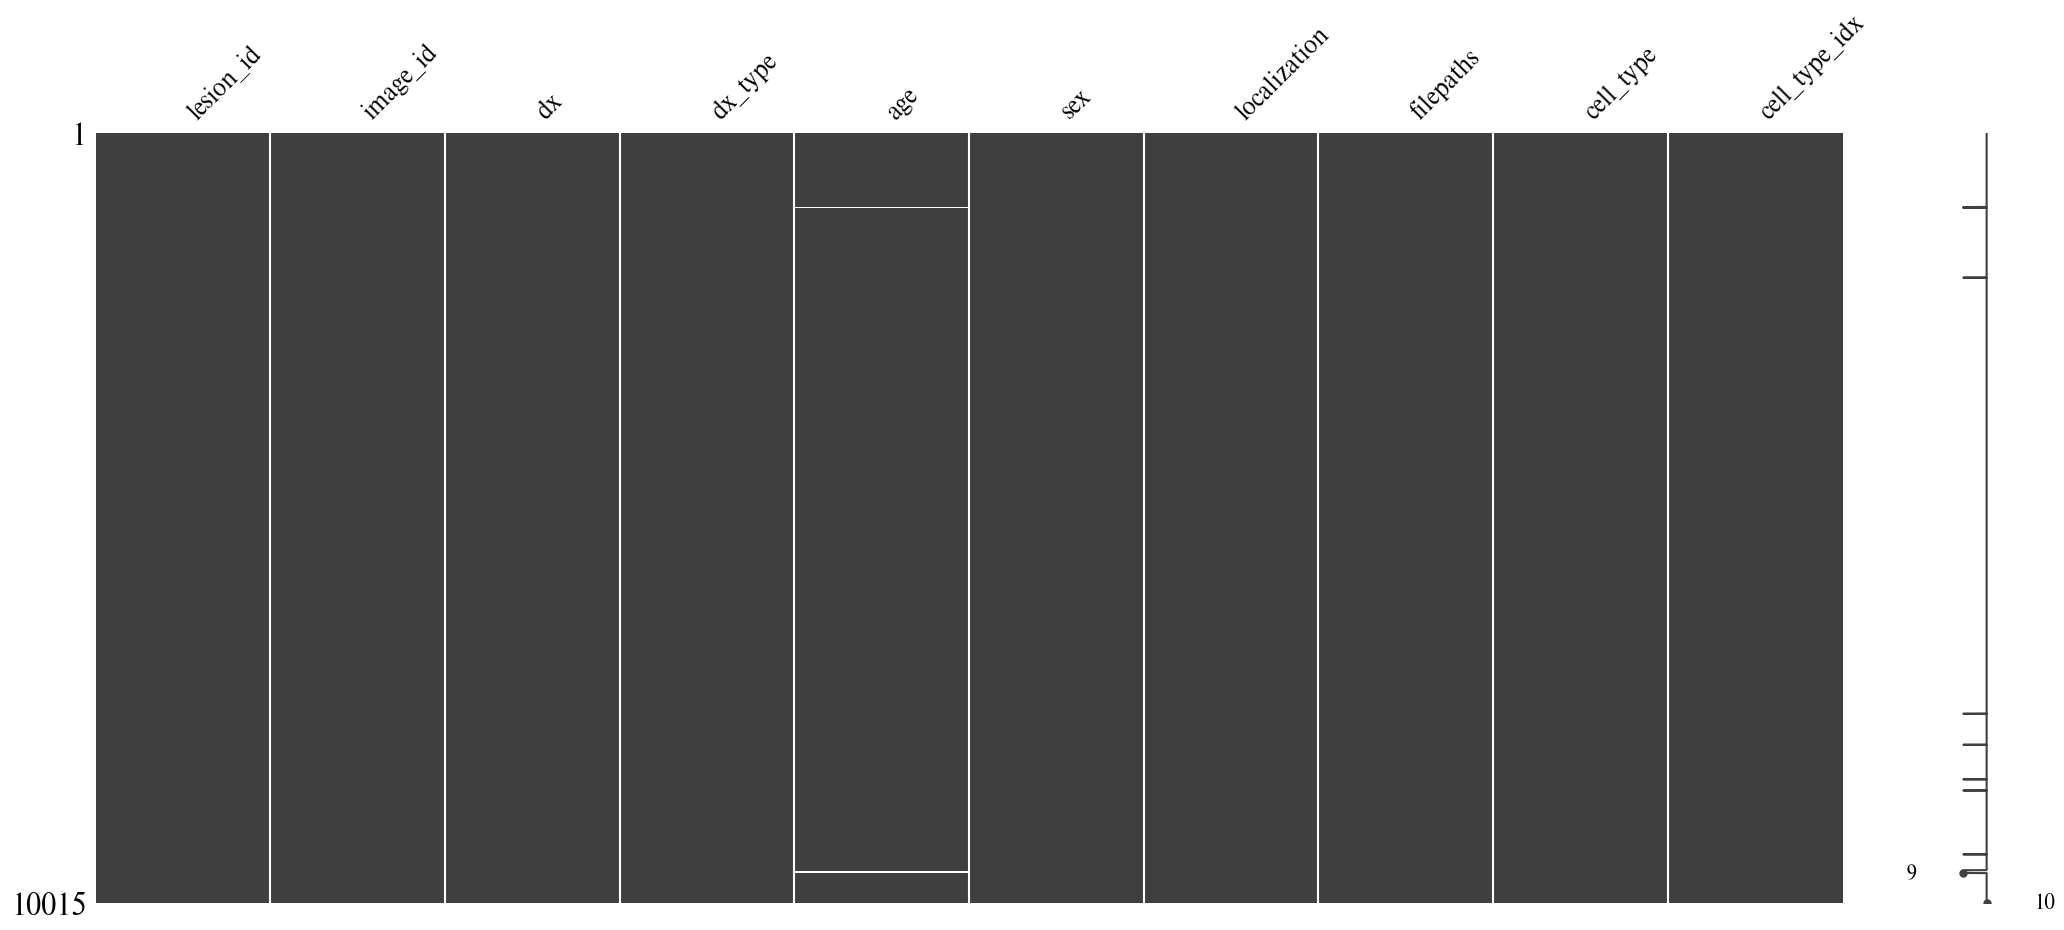

In [15]:
msno.matrix(metadata)

In [16]:
print("Metadata age describe")
print("-------------------------------------------")
print(metadata["age"].describe())
print("Metadata age median")
print("-------------------------------------------")
print(f"Age median: {metadata['age'].median()}")

Metadata age describe
-------------------------------------------
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64
Metadata age median
-------------------------------------------
Age median: 50.0


In [17]:
clean_df = metadata.copy()

In [18]:
age_median = clean_df["age"].median()
clean_df["age"] = clean_df["age"].fillna(age_median) # แทนที่ค่า NaN ด้วยค่ามัธยฐานของอายุ

print("Check missing value")
print("-------------------------------------------")
print(clean_df.isnull().sum())
print("-------------------------------------------")

Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
filepaths        0
cell_type        0
cell_type_idx    0
dtype: int64
-------------------------------------------


<Axes: >

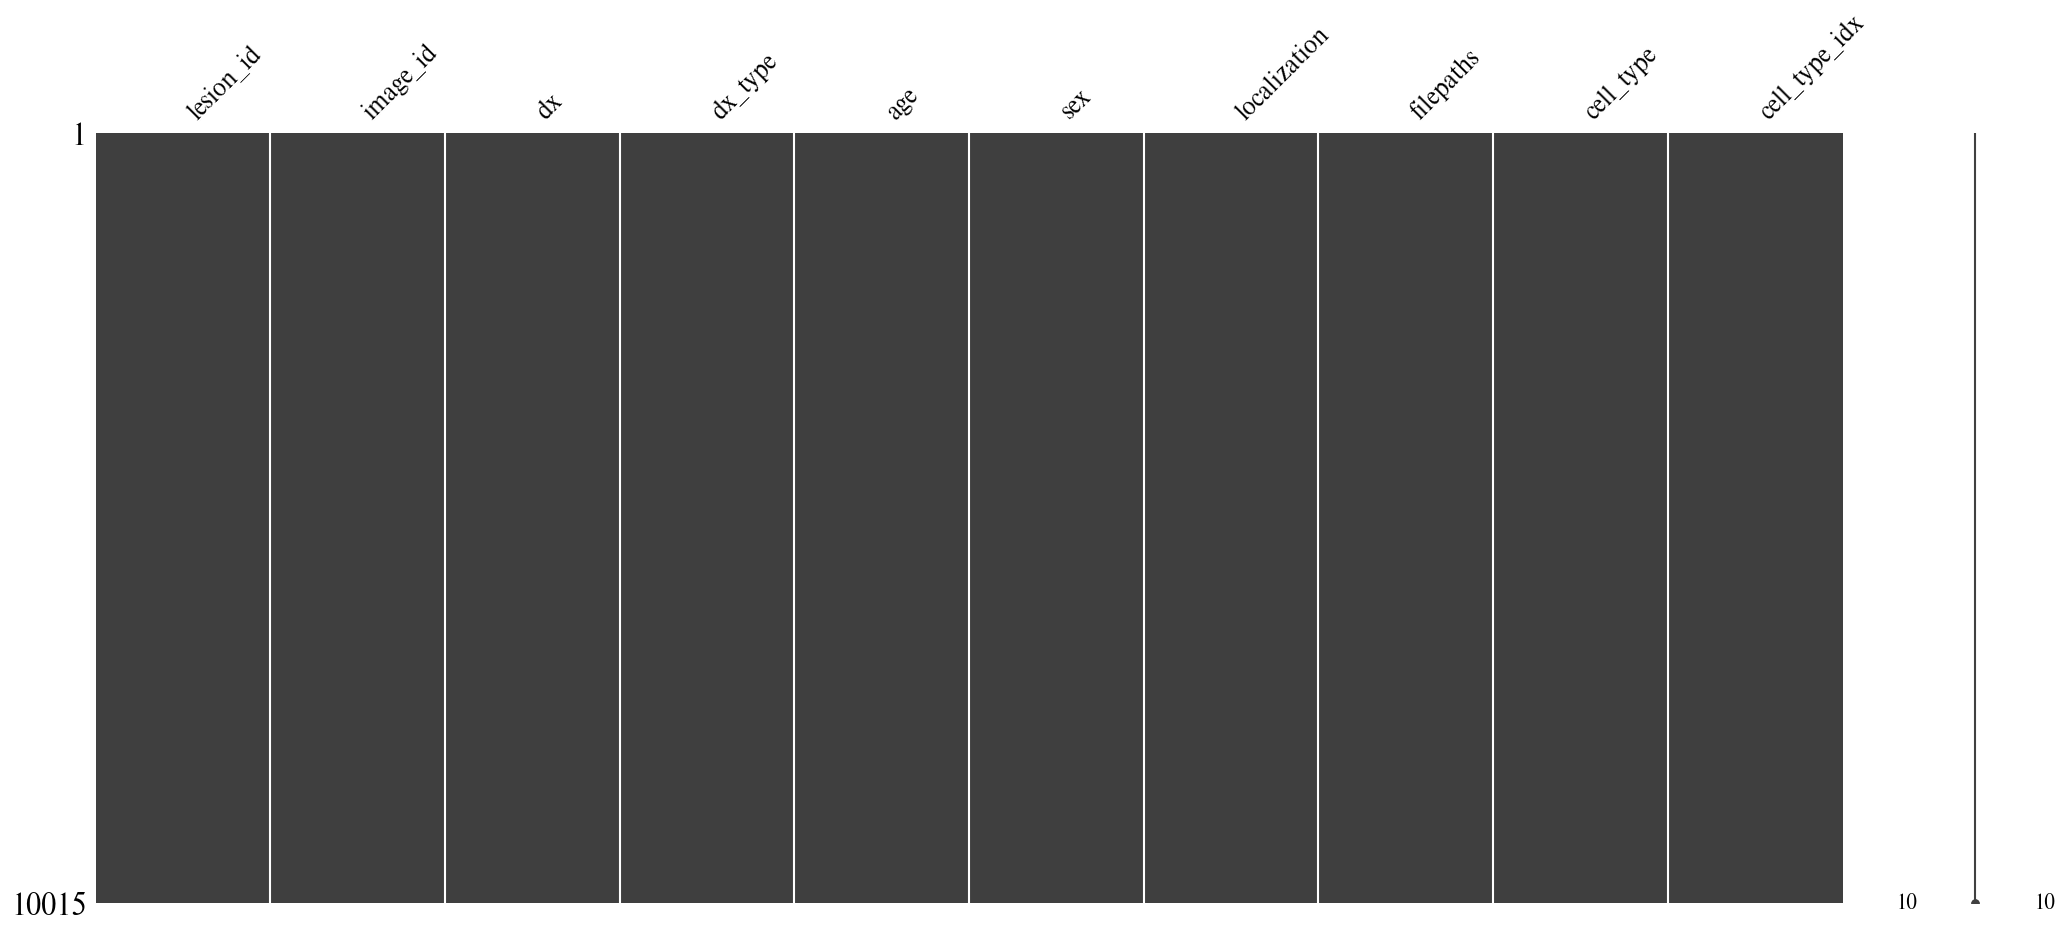

In [19]:
msno.matrix(clean_df)

In [20]:
print("Recheck class index and cell type")
clean_df[["dx", "cell_type", "cell_type_idx"]].drop_duplicates().sort_values("cell_type_idx").reset_index(drop=True)

Recheck class index and cell type


dx                      cell_type  cell_type_idx
0  akiec              Actinic keratoses              0
1    bcc           Basal cell carcinoma              1
2    bkl  Benign keratosis-like lesions              2
3     df                 Dermatofibroma              3
4    mel                       Melanoma              4
5     nv               Melanocytic nevi              5
6   vasc               Vascular lesions              6

### **Univariate EDA**

In [21]:
def plot_univariate_distributions(df, save_path=None, fontsize=20):
    """
    ฟังก์ชันนี้ใช้สร้างกราฟแสดงการแจกแจงตัวแปรเดี่ยว (Univariate Distributions)
    จาก DataFrame ที่มีคอลัมน์ ['age', 'sex', 'dx_type', 'localization']

    Args:
        df (DataFrame): ข้อมูลที่ต้องการวิเคราะห์ โดยต้องมีคอลัมน์ 'age', 'sex', 'dx_type', 'localization'
        save_path (str, optional): ถ้าระบุ จะบันทึกภาพกราฟเป็นไฟล์ PNG และ SVG
        fontsize (int, optional): ขนาดตัวอักษรฐานสำหรับ Label และ Title (default=20)
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    sns.despine(left=True)

    # ---- [0, 0] Age Distribution (KDE) ----
    sns.kdeplot(data=df, x="age", fill=True, color="skyblue", ax=axes[0, 0])
    axes[0, 0].set_xlabel("Age")
    axes[0, 0].set_title("Age Distribution", fontsize=fontsize)

    # ---- [0, 1] Gender Distribution ----
    sns.countplot(data=df, x="sex", hue="sex", palette="pastel", legend=False, ax=axes[0, 1])
    axes[0, 1].set_xlabel("Gender")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].set_title("Gender Distribution", fontsize=fontsize)
    axes[0, 1].tick_params(axis='x', rotation=30)

    # ---- [1, 0] Diagnosis Test Type ----
    sns.countplot(data=df, x="dx_type", hue="dx_type", palette="muted", legend=False, ax=axes[1, 0])
    axes[1, 0].set_xlabel("Diagnosis Test Type")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].set_title("Diagnosis Test Type Distribution", fontsize=fontsize)
    axes[1, 0].tick_params(axis='x', rotation=30)

    # ---- [1, 1] Lesion Localization ----
    sns.countplot(data=df, x="localization", hue="localization", palette="Set2", legend=False, ax=axes[1, 1])
    axes[1, 1].set_xlabel("Localization Area")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].set_title("Localization Area Distribution", fontsize=fontsize)
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle("Univariate Distributions", fontsize=fontsize * 1.2)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

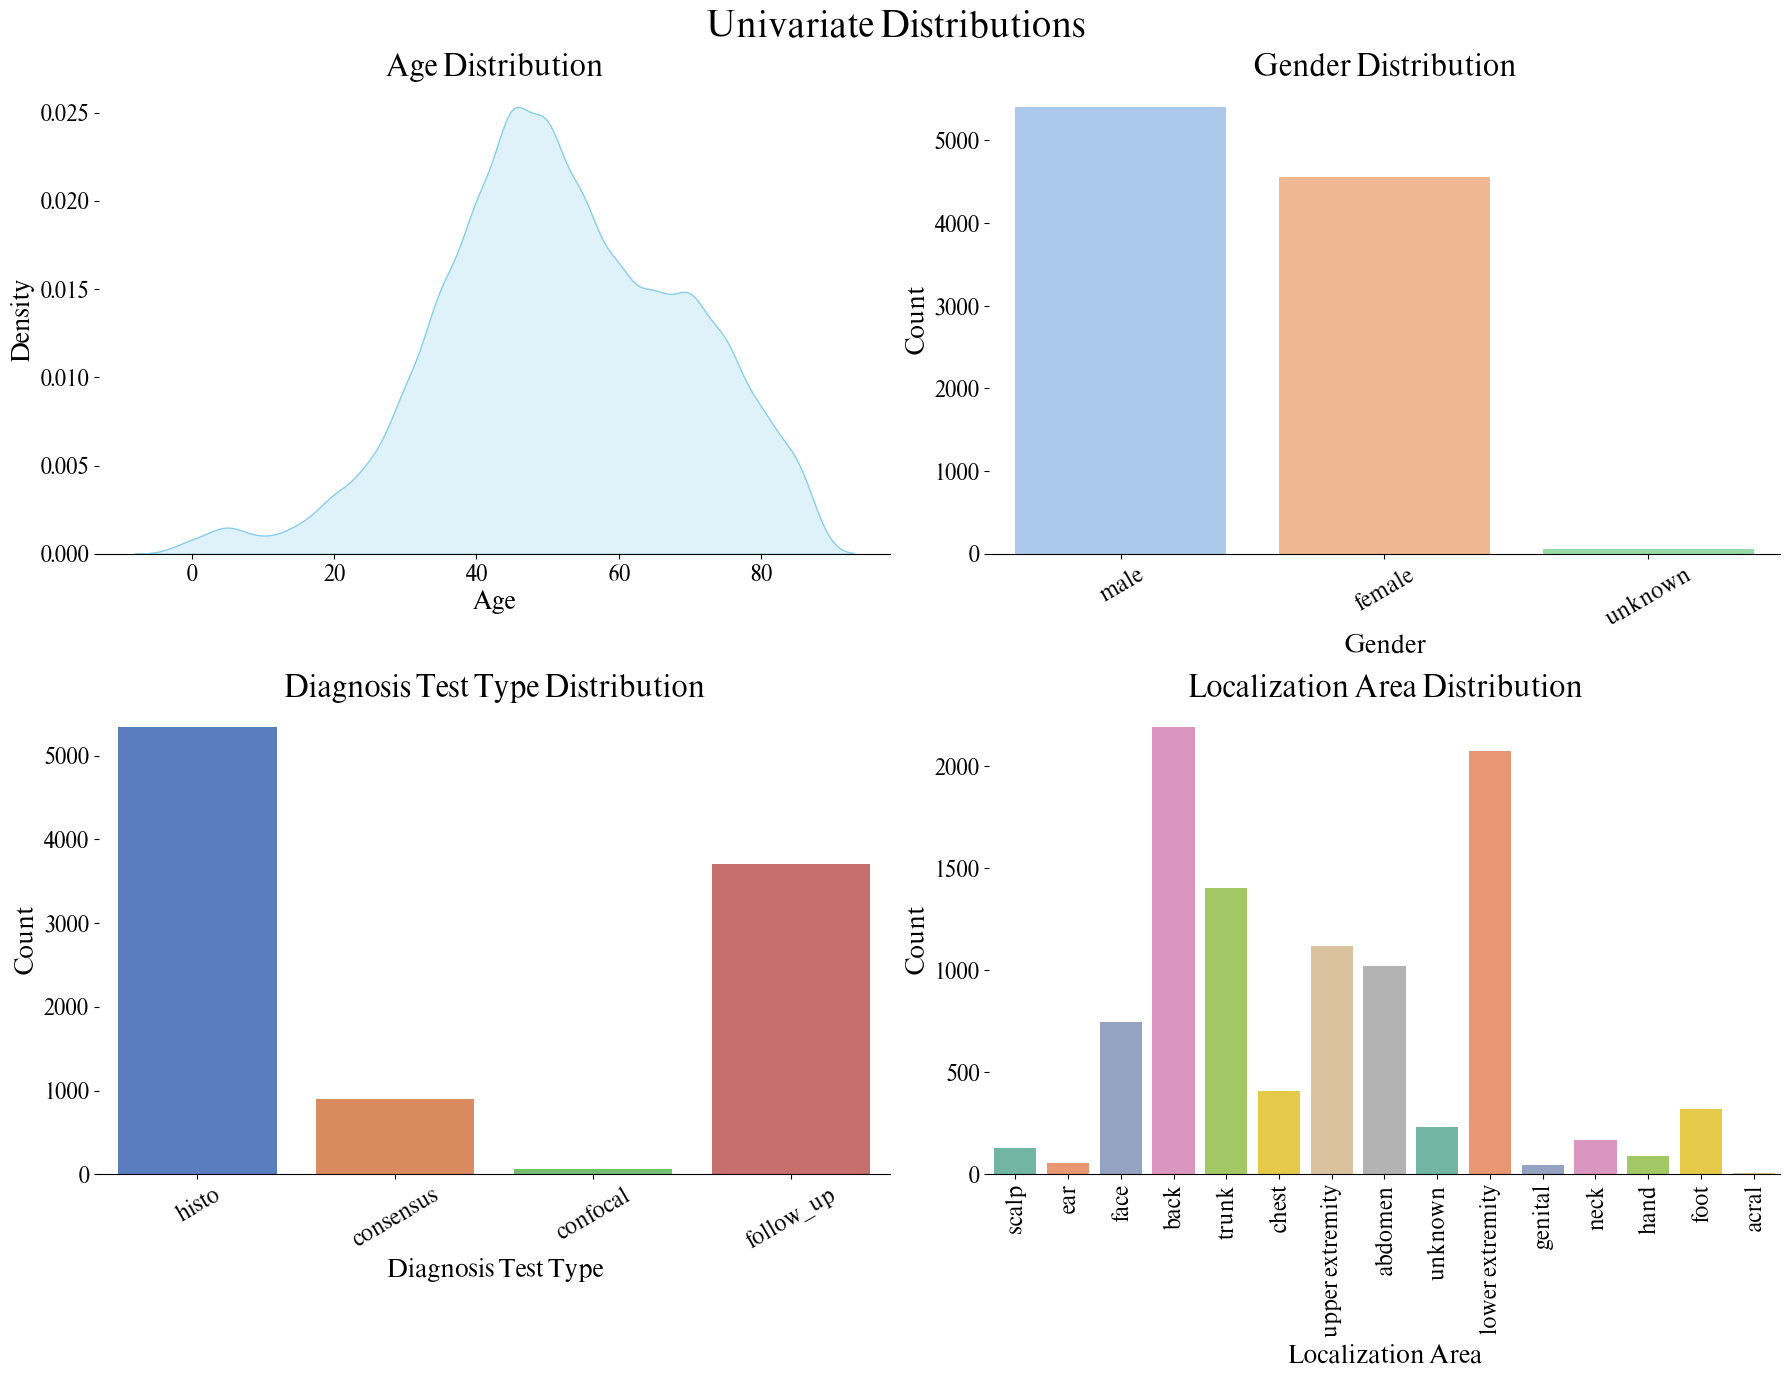

In [22]:
plot_univariate_distributions(
    df=clean_df,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/univariate_distributions",
    fontsize=20
)

### **Bivariate EDA**

In [23]:
def plot_age_boxplots(df, fontsize=20, save_path=None):
    """
    ฟังก์ชันนี้ใช้สร้างกราฟกล่อง (Boxplot) แสดงการกระจายอายุ
    โดยเปรียบเทียบตามเพศ (sex) และประเภทรอยโรค (dx)

    Args:
        df (DataFrame): ข้อมูลที่ต้องมีคอลัมน์ 'age', 'sex', 'dx'
        fontsize (int, optional): ขนาดตัวอักษรฐานสำหรับ labels และ titles
        save_path (str, optional): ถ้าระบุ จะบันทึกกราฟเป็นไฟล์ PNG และ SVG
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.despine(left=True)

    # Gender vs Age
    sns.boxplot(x="sex", y="age", data=df, hue="sex", palette="pastel", legend=False, ax=axes[0])
    axes[0].set_xlabel("Gender")
    axes[0].set_ylabel("Age")
    axes[0].set_title("Gender vs Age Boxplot", fontsize=fontsize-2)
    axes[0].tick_params(axis="x", rotation=30)

    # Lesion Type vs Age
    sns.boxplot(x="dx", y="age", data=df, hue="dx", palette="muted", legend=False, ax=axes[1])
    axes[1].set_xlabel("Lesion Type")
    axes[1].set_ylabel("Age")
    axes[1].set_title("Lesion Type vs Age Boxplot", fontsize=fontsize-2)
    axes[1].tick_params(axis="x", rotation=30)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle("Bivariate Distribution", fontsize=fontsize * 1.1)

    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

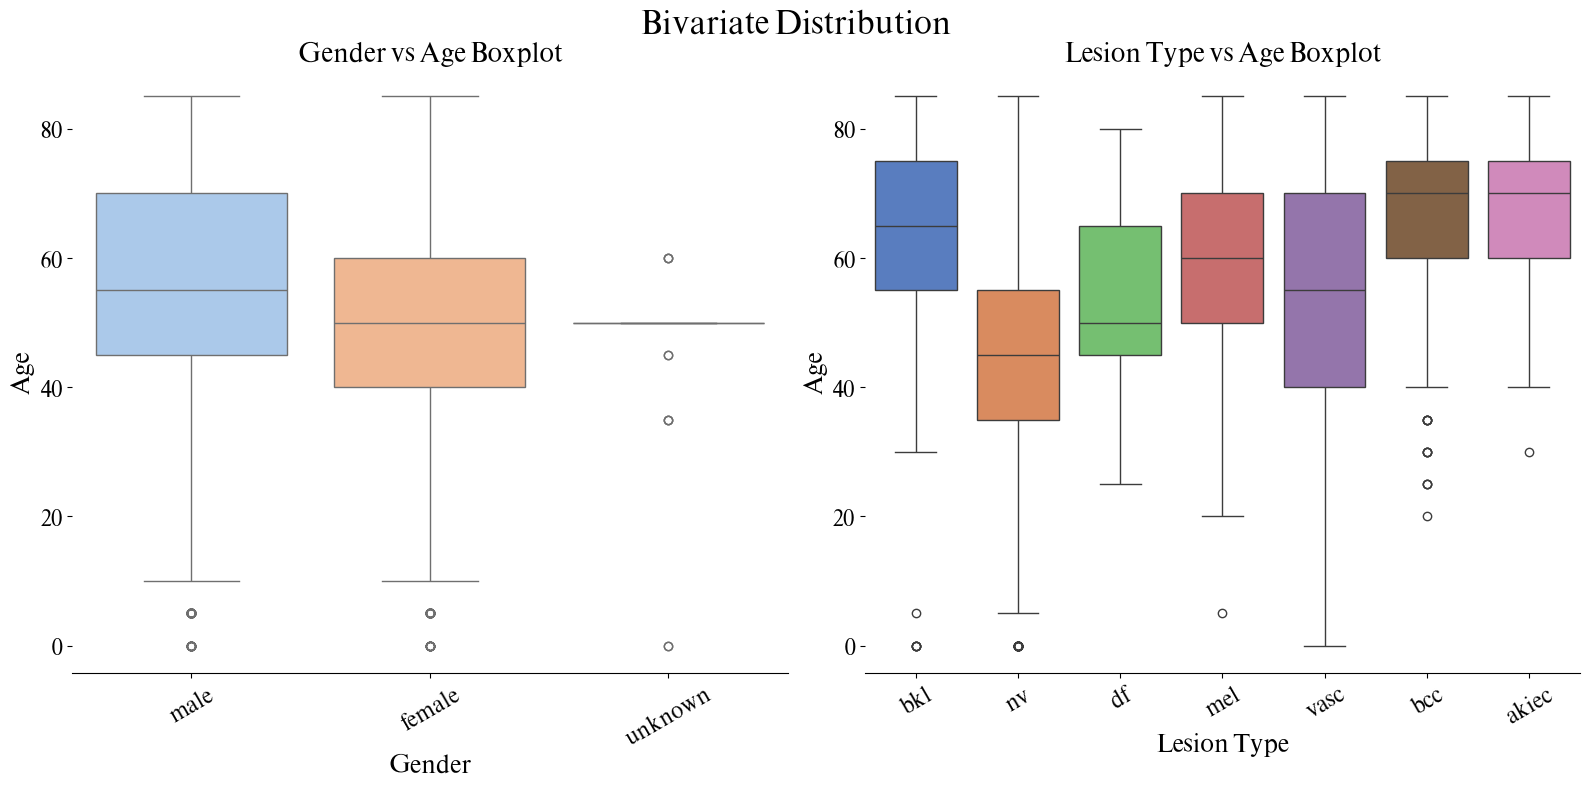

In [24]:
plot_age_boxplots(
    df=clean_df,
    fontsize=20,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/bivariate_distributions"
)

In [115]:
def plot_bivariate_distributions(df, save_path=None, fontsize=20):
    """
    แสดงความสัมพันธ์ระหว่าง metadata (age, sex, localization) กับ target (dx)
    ในรูปแบบ 1 แถว 3 คอลัมน์
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(1, 3, figsize=(26, 7))
    sns.despine(left=True)

    # ---- [0] Age vs DX (Boxplot) ----
    sns.boxplot(data=df, x="dx", y="age", hue="dx", palette="coolwarm", legend=False, ax=axes[0])
    axes[0].set_title("Age vs Diagnosis (dx)")
    axes[0].set_xlabel("Diagnosis")
    axes[0].set_ylabel("Age")
    axes[0].tick_params(axis='x', rotation=45)

    # ---- [1] Sex vs DX (Countplot) ----
    sns.countplot(data=df, x="dx", hue="sex", palette="pastel", ax=axes[1])
    axes[1].set_title("Gender Distribution by Diagnosis")
    axes[1].set_xlabel("Diagnosis")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title="Gender", loc="upper right", fontsize=fontsize * 0.6)

    # ---- [2] Localization vs DX (Countplot) ----
    sns.countplot(data=df, x="dx", hue="localization", palette="Set2", ax=axes[2])
    axes[2].set_title("Localization Distribution by Diagnosis")
    axes[2].set_xlabel("Diagnosis")
    axes[2].set_ylabel("Count")
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title="Localization", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=fontsize * 0.6)

    # ---- Layout ----
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("Bivariate Distributions: Age, Sex, Localization vs DX", fontsize=fontsize * 1.2)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

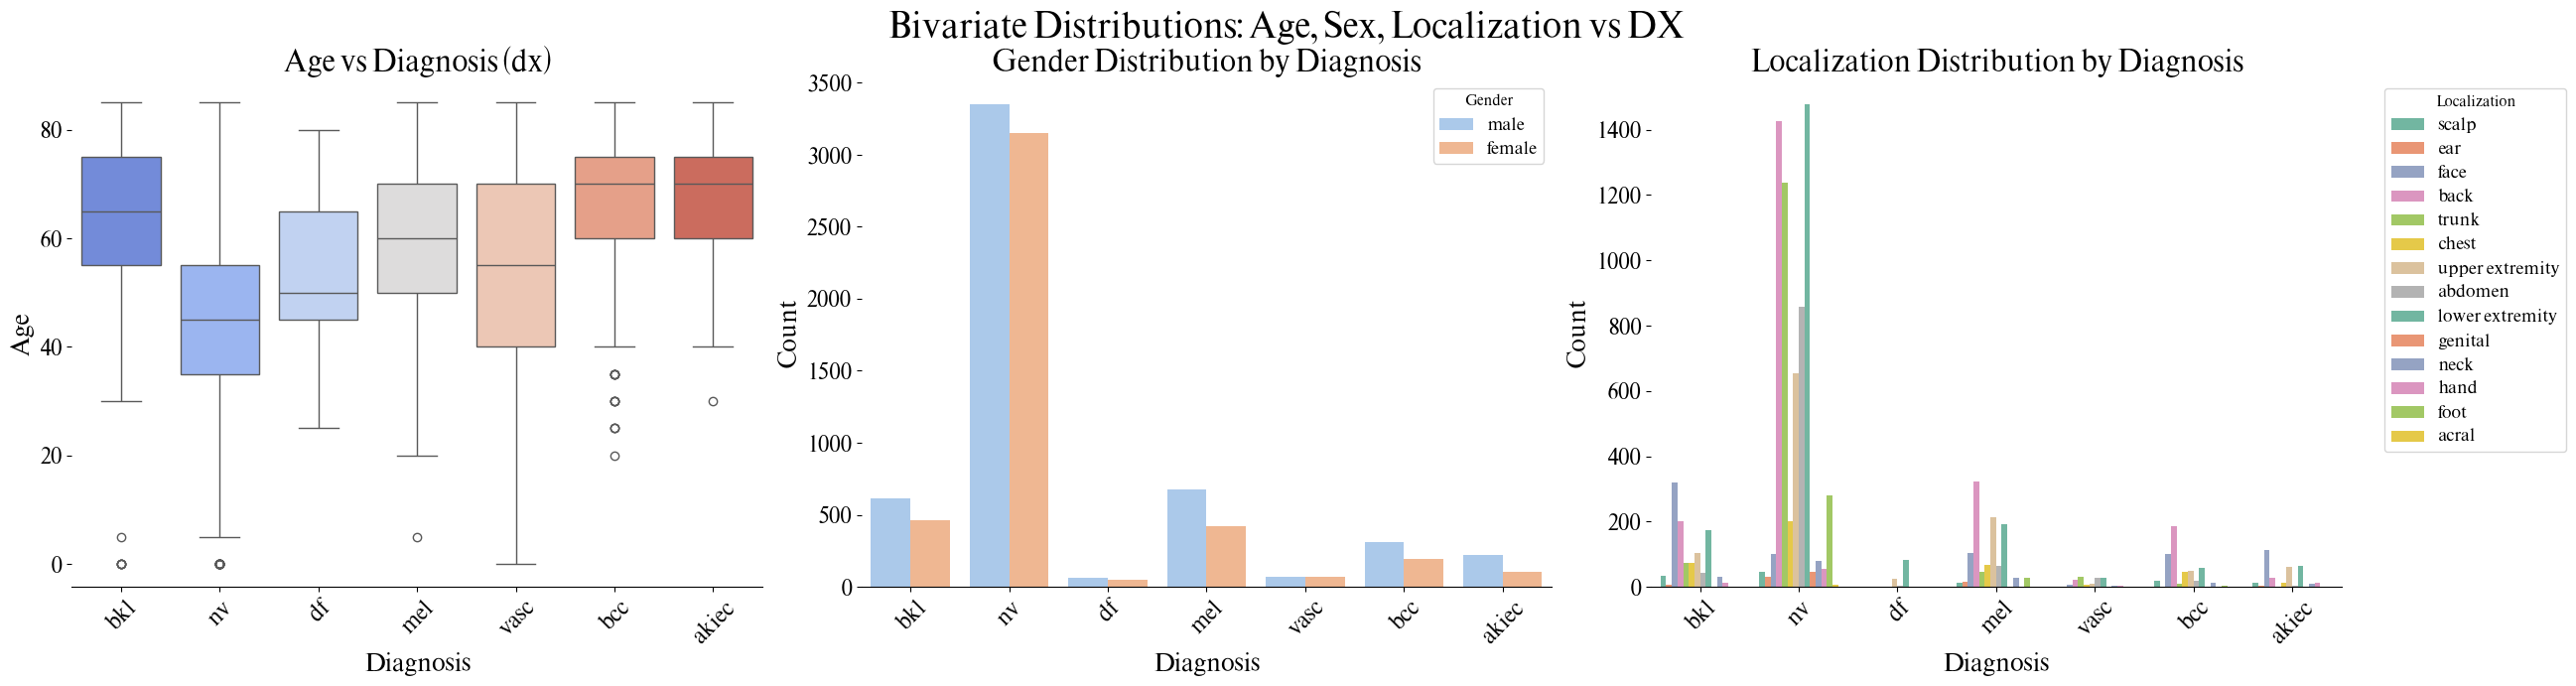

In [116]:
plot_bivariate_distributions(
    df=clean_df,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/bivariate_distributions_2",
    fontsize=20
)

### **Handle unknown value for gender column**

In [25]:
print("Gender feature before cleaning:")
print(clean_df["sex"].value_counts())

Gender feature before cleaning:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


In [26]:
clean_df = clean_df[clean_df["sex"] != "unknown"]
print(f"Gender feature after cleaning:")
print(clean_df["sex"].value_counts())

Gender feature after cleaning:
sex
male      5406
female    4552
Name: count, dtype: int64


### **Handle unknown value for localization area column**

In [27]:
print(f"Localization feature before cleaning:")
print(clean_df["localization"].value_counts())

Localization feature before cleaning:
localization
back               2190
lower extremity    2077
trunk              1401
upper extremity    1118
abdomen            1020
face                745
chest               407
foot                316
unknown             187
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


In [28]:
clean_df = clean_df[clean_df["localization"] != "unknown"]
print(f"Localization feature after cleaning:")
print(clean_df["localization"].value_counts())

Localization feature after cleaning:
localization
back               2190
lower extremity    2077
trunk              1401
upper extremity    1118
abdomen            1020
face                745
chest               407
foot                316
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


### **EDA Summary**

In [29]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {clean_df.shape}")
print(f"Row of metadata: {clean_df.shape[0]}")
print(f"Column of metadata: {clean_df.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(clean_df.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(clean_df.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {clean_df.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (9771, 10)
Row of metadata: 9771
Column of metadata: 10
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
filepaths        0
cell_type        0
cell_type_idx    0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id          object
image_id           object
dx                 object
dx_type            object
age               float64
sex                object
localization       object
filepaths          object
cell_type        category
cell_type_idx        int8
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


### **Export metadata after cleaning**

In [ ]:
clean_df.to_csv(f"{INDEX_PATH}/metadata_cleaning.csv", index=False)

## **Section 3: Verify the images**

In [30]:
process_df = clean_df.copy()
process_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                               filepaths  \
0      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                  ...   
10010  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10011  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10012  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10013  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10014  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[9771 rows x 10 columns]

In [ ]:
def verify_images(df, filepaths_col):
    """
        สำหรับตรวจสอบรูปภาพ เพื่อสแกนหาว่ามีภาพที่เสียหรือเปิดไม่ได้หรือไม่
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        Return:
            List ที่เก็บชื่อไฟล์ที่พบปัญหา
    """
    corrupted_images = []
    filepaths = df[filepaths_col].values

    for filepath in tqdm(filepaths, desc="Verifying Images"):
        try:
            img = cv2.imread(filepath)
            if img is None:
                corrupted_images.append(filepath)
                os.remove(filepath) # ถ้าเจอภาพเสียลบออก
                print(f"Corrupted or unreadable image removed: {filepath}")
        except Exception as e:
            corrupted_images.append(filepath)
            os.remove(filepath) # ถ้าเจอภาพเสียลบออก
            print(f"Error verifying image: {filepath} - {e}")

    return corrupted_images

In [ ]:
corrupted_images = verify_images(process_df, "filepaths")

Verifying Images: 100%|██████████| 9771/9771 [02:46<00:00, 58.84it/s]


In [ ]:
print(f"Number of corrupted images: {len(corrupted_images)}")

Number of corrupted images: 0


## **Section 4: Split data into Train, Validation and Test**

**Split data into ratio train 80 validation 10 and test 10 From Original Paper**

In [31]:
df_train_original, df_temp = sklearn.model_selection.train_test_split(
    metadata, # แบ่งจาก Metadata ที่มีข้อมูลภาพครบ ๆ
    test_size=0.2,
    stratify=metadata["cell_type_idx"],
    random_state=SEED
)

df_val_original, df_test_original = sklearn.model_selection.train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["cell_type_idx"],
    random_state=SEED
)

In [32]:
total_original_images = len(metadata)

print(f"Total original images: {total_original_images}")
print(f"Train original images: {len(df_train_original)} ({len(df_train_original)/total_original_images*100:.2f}%)")
print(f"Val original images:   {len(df_val_original)} ({len(df_val_original)/total_original_images*100:.2f}%)")
print(f"Test original images:  {len(df_test_original)} ({len(df_test_original)/total_original_images*100:.2f}%)")
print(f"Sum original images:   {len(df_train_original) + len(df_val_original) + len(df_test_original)}")
print("-" * 30)

Total original images: 10015
Train original images: 8012 (80.00%)
Val original images:   1001 (10.00%)
Test original images:  1002 (10.00%)
Sum original images:   10015
------------------------------


**Split data into ratio train 80 validation 10 and test 10 Based on Valid Metadata**

In [33]:
# หา Unique ตัวแบ่งกลุ่มที่จะ Split ข้อมูลโดยที่ไม่ซ้ำ
lesion_id = process_df.drop_duplicates(subset="lesion_id")
lesion_id = lesion_id[["lesion_id", "cell_type_idx"]]
print(f"Total images: {len(lesion_id)}")
print(f"Total unique lesions: {len(lesion_id)}")

Total images: 7263
Total unique lesions: 7263


In [34]:
train_lesions, temp_lesions = sklearn.model_selection.train_test_split(
    lesion_id,
    test_size=0.2,
    stratify=lesion_id["cell_type_idx"],
    random_state=SEED
)

val_lesions, test_lesions = sklearn.model_selection.train_test_split(
    temp_lesions,
    test_size=0.5,
    stratify=temp_lesions["cell_type_idx"],
    random_state=SEED
)

print(f"Total lesions: {len(lesion_id)}")
print(f"Train lesions: {len(train_lesions)}")
print(f"Val lesions:   {len(val_lesions)}")
print(f"Test lesions:  {len(test_lesions)}")

Total lesions: 7263
Train lesions: 5810
Val lesions:   726
Test lesions:  727


In [35]:
train_ids = set(train_lesions["lesion_id"])
val_ids = set(val_lesions["lesion_id"])
test_ids = set(test_lesions["lesion_id"])

In [36]:
df_train = process_df[process_df["lesion_id"].isin(train_ids)].copy()
df_val = process_df[process_df["lesion_id"].isin(val_ids)].copy()
df_test = process_df[process_df["lesion_id"].isin(test_ids)].copy()

In [37]:
total_images = len(clean_df)

print(f"Total original images: {total_images}")
print(f"Train images: {len(df_train)} ({len(df_train)/total_images*100:.2f}%)")
print(f"Val images:   {len(df_val)} ({len(df_val)/total_images*100:.2f}%)")
print(f"Test images:  {len(df_test)} ({len(df_test)/total_images*100:.2f}%)")
print(f"Sum images:   {len(df_train) + len(df_val) + len(df_test)}")
print("-" * 30)

train_val_overlap = np.intersect1d(df_train["lesion_id"], df_val["lesion_id"])
train_test_overlap = np.intersect1d(df_train["lesion_id"], df_test["lesion_id"])
val_test_overlap = np.intersect1d(df_val["lesion_id"], df_test["lesion_id"])

# เพื่อรับประกันว่าข้อมูลจะไม่รั่วไหล
print(f"Overlap Train-Val: {len(train_val_overlap)}")
print(f"Overlap Train-Test: {len(train_test_overlap)}")
print(f"Overlap Val-Test: {len(val_test_overlap)}")

Total original images: 9771
Train images: 7832 (80.16%)
Val images:   984 (10.07%)
Test images:  955 (9.77%)
Sum images:   9771
------------------------------
Overlap Train-Val: 0
Overlap Train-Test: 0
Overlap Val-Test: 0


## **Section 5: Create dataset tree directory**

In [38]:
def merge_directory(df_train, df_val, df_test,
                    filepaths_col, labels_col,
                    dest_dir, zip_dir=None):
    """
        สำหรับการ Merge source directories ตั้งแต่ 2 แหล่งขึ้นไป รวมเป็น 1 เดียว พร้อมกับสร้าง Sub folder ตาม Label ของแต่ละภาพ
        Structure folder:
            Main folder
            |
            |__train
               |_classA
                    |_IMG_1.jpg
               |_classB
                    |_IMG_2.jpg
            |__val
               |_classA
                    |_IMG_1.jpg
               |_classB
                    |_IMG_2.jpg
            |__test
               |_classA
                    |_IMG_1.jpg
               |_classB
                    |_IMG_2.jpg

        Args:
            df_train, df_val, df_test : DataFrame ของแต่ละชุดข้อมูล
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            dest_dir คือ directory ปลายทาง
            zip_dir (optional) รับค่าเป็น Path ไฟล์เพื่อ zip ไฟล์เก็บไว้
    """
    os.makedirs(dest_dir, exist_ok=True)
    print(f"Destination directory has been created at: {dest_dir}")

    datasets = {
        "train": df_train,
        "val": df_val,
        "test": df_test
    }

    for split_name, df in datasets.items():
        print(f"\nProcessing {split_name} set ({len(df)} images)...")

        split_dir = os.path.join(dest_dir, split_name)
        os.makedirs(split_dir, exist_ok=True)

        # สร้าง subfolder ตาม label
        labels = df[labels_col].unique().tolist()
        for label in labels:
            label_dir = os.path.join(split_dir, label)
            os.makedirs(label_dir, exist_ok=True)

        # คัดลอกไฟล์
        filepaths = df[filepaths_col].values
        image_labels = df[labels_col].values

        for src_path, image_label in tqdm(
            zip(filepaths, image_labels),
            total=len(df),
            desc=f"Copying {split_name}"
        ):
            filename = os.path.basename(src_path)
            dst_path = os.path.join(split_dir, image_label, filename)
            shutil.copyfile(src_path, dst_path)

    if zip_dir:
        shutil.make_archive(zip_dir, "zip", dest_dir)
        print(f"Zip file has been created at: {zip_dir}")

In [39]:
def update_path(df_train, df_val, df_test,
                base_path, filepaths_col, labels_col):
    """
    ฟังก์ชันนี้ใช้อัปเดตเส้นทางไฟล์ (file path) ใน DataFrame
    โดยรวม base_path, label และชื่อไฟล์เข้าด้วยกัน

    Args:
        df_train, df_val, df_test : DataFrame ของแต่ละชุดข้อมูล
        base_path (str): โฟลเดอร์หลักของไฟล์
        filepaths_col (str): ชื่อคอลัมน์ที่เก็บ path ของไฟล์เดิม
        labels_col (str): ชื่อคอลัมน์ที่เก็บ label ของไฟล์

    Returns:
        (df_train, df_val, df_test): DataFrame ทั้งสามชุดที่อัปเดต path แล้ว
    """
    def update_single(df, split_name):
        split_path = os.path.join(base_path, split_name)
        filenames = df[filepaths_col].apply(os.path.basename)
        labels = df[labels_col]
        df[filepaths_col] = split_path + "/" + labels + "/" + filenames
        return df

    df_train = update_single(df_train.copy(), "train")
    df_val = update_single(df_val.copy(), "val")
    df_test = update_single(df_test.copy(), "test")

    print(f"Updated paths for train ({len(df_train)}), val ({len(df_val)}), test ({len(df_test)})")
    return df_train, df_val, df_test

In [40]:
merge_directory(
    df_train=df_train_original,
    df_val=df_val_original,
    df_test=df_test_original,
    filepaths_col="filepaths",
    labels_col="dx",
    dest_dir=BASE_DATASET_DIR,
    zip_dir=DATASET_ZIP_PATH
)

Destination directory has been created at: /content/ham10000Dataset

Processing train set (8012 images)...


Copying train: 100%|██████████| 8012/8012 [01:45<00:00, 76.14it/s]



Processing val set (1001 images)...


Copying val: 100%|██████████| 1001/1001 [00:12<00:00, 80.22it/s]



Processing test set (1002 images)...


Copying test: 100%|██████████| 1002/1002 [00:13<00:00, 73.63it/s]


Zip file has been created at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000Dataset


In [41]:
df_train_original, df_val_original, df_test_original = update_path(
    df_train=df_train_original,
    df_val=df_val_original,
    df_test=df_test_original,
    base_path=BASE_DATASET_DIR,
    filepaths_col="filepaths",
    labels_col="dx"
) # Rename path to match new path

Updated paths for train (8012), val (1001), test (1002)


In [42]:
df_train_original.to_csv(f"{INDEX_PATH}/metadata_train_original.csv", index=False)
df_val_original.to_csv(f"{INDEX_PATH}/metadata_val_original.csv", index=False)
df_test_original.to_csv(f"{INDEX_PATH}/metadata_test_original.csv", index=False)

## **Section 6: Visualization images**

In [43]:
def plot_distribution(df, labels_col, save_path=None, fontsize=18, title="Class Distribution"):
    """
        แสดงจำนวนรูปภาพในแต่ละ Class แบบ Bar plot
        Args:
            df คือ Pandas dataframe ที่มี Column Label สำหรับอ้างอิง Label ของภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
    """
    class_counts = df[labels_col].value_counts().reset_index()
    class_counts.columns = [labels_col, "count"]

    classes = sorted(df[labels_col].unique())
    palette = sns.color_palette("viridis", n_colors=len(classes))
    class_palette = {cls: palette[i] for i, cls in enumerate(classes)}

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=labels_col,
        y="count",
        data=class_counts,
        hue=labels_col,
        palette=class_palette,
        dodge=False,
        legend=False,
        order=classes
    )

    plt.title(title, fontsize=fontsize+2, weight="bold")
    plt.xlabel("Classes", fontsize=fontsize)
    plt.ylabel("Number of Images", fontsize=fontsize)
    plt.xticks(rotation=45, ha="right", fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    for i, count in enumerate(class_counts.set_index(labels_col).loc[classes]["count"]):
        plt.text(i, count, str(count), ha="center", va="bottom", fontsize=fontsize-2)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

In [44]:
def visualize_image_by_class(df, filepaths_col, labels_col, labels_dict, save_path=None, fontsize=20, title="HAM10000 Dataset", num_images=7):
    """
        แสดงรูปภาพ Sample โดยแยกตาม Label ในแต่ละ Row
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            labels_dict คือ dict ที่เก็บ key เป็นชื่อย่อของ Label และ value เป็นชื่อเต็มของ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
            num_images คือ จำนวนรูปภาพที่ต้องการแสดงในแต่ละแถว
    """
    unique_labels = df[labels_col].unique()
    num_classes = len(unique_labels)

    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, label in enumerate(unique_labels):
        label_df = df[df[labels_col] == label]
        sample_paths = label_df[filepaths_col].sample(
            n=min(num_images, len(label_df)),
            random_state=SEED
        ).tolist()

        for j, filepath in enumerate(sample_paths):
            ax = plt.subplot(num_classes, num_images, i * num_images + j + 1)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis("off")

            if j == 0:
                fullname = labels_dict.get(label, label)
                ax.set_title(f"{fullname} ({label})", loc="left", fontsize=fontsize, pad=10)

    plt.suptitle(title, fontsize=fontsize+2, weight="bold")
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

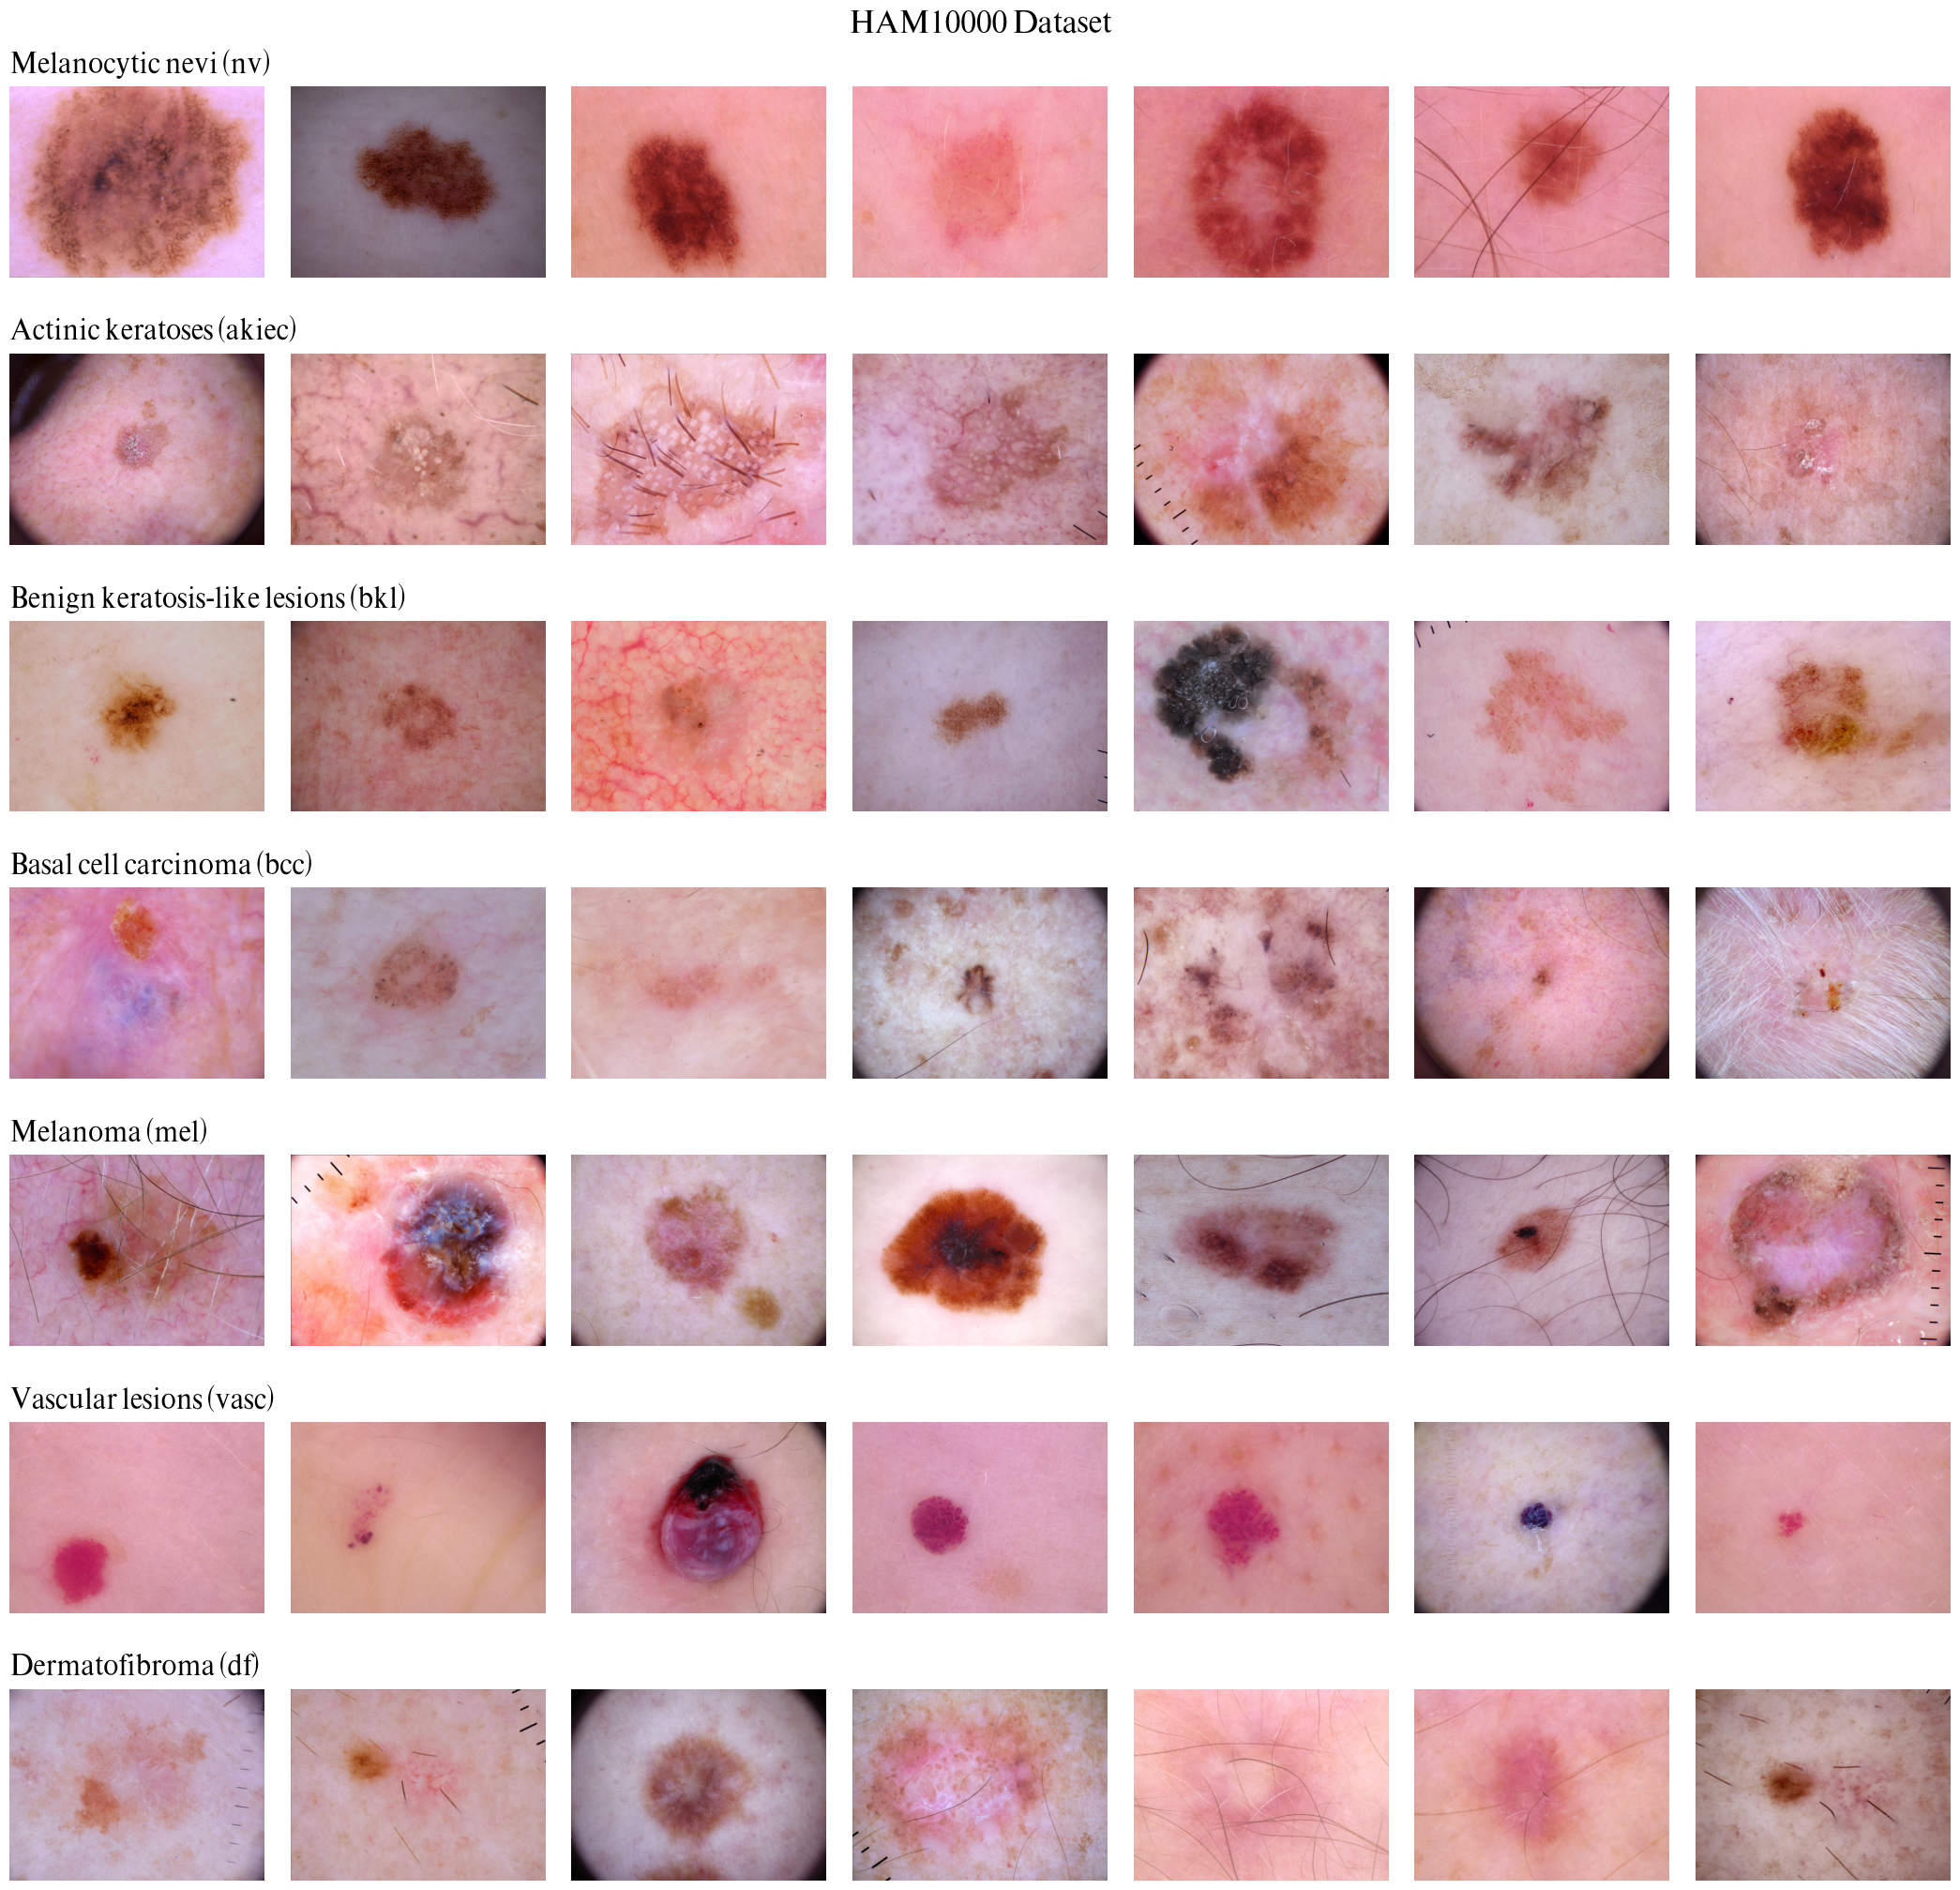

In [45]:
visualize_image_by_class(
    df=df_train_original,
    filepaths_col="filepaths",
    labels_col="dx",
    labels_dict=lesion_type_dict,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/visualize_by_class",
    fontsize=20
)

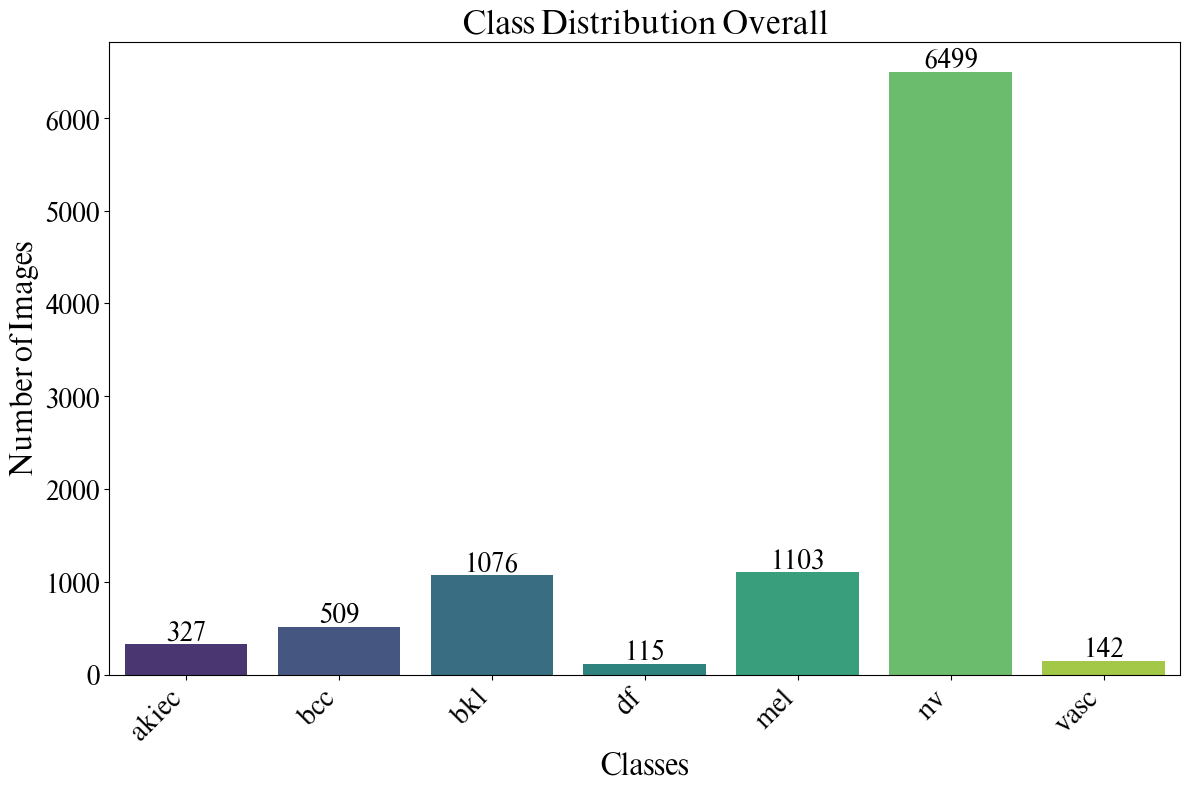

In [46]:
plot_distribution(
    df=process_df,
    labels_col="dx",
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/class_distribution",
    fontsize=20,
    title="Class Distribution Overall"
)

## **Section 7: Visualization and fixed imbalanced for training data by transfrom image**

In [47]:
def visualize_augmentation(df, filepaths_col, transforms_sample, title,
                         n_rows, n_cols, n_samples=1,
                         seed=42, save_path=None, fontsize=16):
    """
    แสดงภาพต้นฉบับและภาพ Augmentation ใน Grid

    Args:
        df: DataFrame ที่มีคอลัมน์ Filepaths
        filepaths_col: ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        transforms_sample: list ของ tuple (name, albumentations transform)
        title: ชื่อ Title หลัก
        n_rows: จำนวนแถว
        n_cols: จำนวนหลัก
        n_samples: จำนวนภาพตัวอย่าง
        seed: random_state สำหรับ sample
        save_path: path สำหรับบันทึกรูป
        fontsize: ขนาดตัวอักษรของ title
    """
    samples = df.sample(n=n_samples, random_state=seed)

    for idx, row in samples.iterrows():
        img_path = row[filepaths_col]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        n_aug = len(transforms_sample)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
        axes = axes.flatten()

        # Original image
        axes[0].imshow(img)
        axes[0].set_title("Original Image", fontsize=fontsize)
        axes[0].axis("off")

        # Augmented images
        for i, (name, aug) in enumerate(transforms_sample):
            aug_img = aug(image=img)["image"]
            axes[i+1].imshow(aug_img)
            axes[i+1].set_title(name, fontsize=fontsize)
            axes[i+1].axis("off")

        # ปิดแกนที่เหลือ
        for j in range(n_aug+1, len(axes)):
            axes[j].axis("off")

        fig.suptitle(title, fontsize=fontsize+2)
        plt.tight_layout()

        if save_path:
            plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

        plt.show()

In [48]:
def apply_transform_to_target(df, filepaths_col, labels_col, transform, base_dir, zip_dir=None,
                              max_target_ratio=0.5, max_aug_factor=4):
    """
    Args:
        df: DataFrame ของ train set
        filepaths_col: ชื่อ column ที่เก็บ path ของภาพ
        labels_col: ชื่อ column ที่เก็บ label
        transform: Albumentations transform object
        base_dir: โฟลเดอร์หลักของ dataset (สมมติว่า path ภาพเดิมอยู่ใน subfolder ของ base_dir)
        zip_dir (optional): path สำหรับ zip ผลลัพธ์ (ไม่ต้องใส่ .zip)
        max_target_ratio: augment เพิ่มจนถึงสัดส่วนเท่านี้ของคลาสใหญ่สุด (ค่าแนะนำ 0.5)
        max_aug_factor: augment ไม่เกิน x เท่าของจำนวนต้นฉบับในคลาสนั้น

    Returns:
        train_df_aug: DataFrame ของ train set หลัง augment (รวม original + augmented)
    """
    df = df.copy()
    new_rows = []

    class_counts = df[labels_col].value_counts()
    max_count = class_counts.max()

    print(f"Max class has {max_count} images")
    print(f"Augmenting minority classes (up to ratio={max_target_ratio}, max factor={max_aug_factor})\n")

    for label, count in class_counts.items():
        target_count = int(min(max_count * max_target_ratio, count * max_aug_factor))
        target_to_add = target_count - count

        if target_to_add <= 0:
            print(f"Skipping class '{label}' ({count} images)")
            continue

        print(f"\nClass '{label}': {count} → {target_count} (need +{target_to_add} new images)")
        class_df = df[df[labels_col] == label]

        sample_path = class_df[filepaths_col].iloc[0]
        class_output_dir = os.path.dirname(sample_path)

        if not os.path.exists(class_output_dir):
             print(f"Error: Output directory not found at {class_output_dir}. Skipping class {label}.")
             continue

        pbar = tqdm(total=target_to_add, desc=f"Augmenting {label}")

        for i in range(target_to_add):
            row_orig = class_df.sample(1).iloc[0]
            img_path = row_orig[filepaths_col]

            if not os.path.exists(img_path):
                 print(f"Warning: Original file not found at {img_path}, skipping augmentation for this instance.")
                 continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path}, skipped.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = transform(image=img)["image"]

            base_name = os.path.splitext(os.path.basename(img_path))[0]
            new_filename = f"{base_name}_aug_{i+1}.jpg"
            save_path = os.path.join(class_output_dir, new_filename)

            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

            new_row = row_orig.copy()
            new_row[filepaths_col] = save_path
            new_rows.append(new_row)

            pbar.update(1)

        pbar.close()

    augmented_df = pd.DataFrame(new_rows)
    train_df_aug = pd.concat([df, augmented_df], ignore_index=True)

    if zip_dir:
        if not os.path.isabs(zip_dir):
            zip_dir = os.path.join(os.getcwd(), zip_dir)

        root_dir_zip = os.path.dirname(base_dir)
        base_dir_zip = os.path.basename(base_dir)

        if root_dir_zip and base_dir_zip:
             shutil.make_archive(zip_dir, "zip", root_dir=root_dir_zip, base_dir=base_dir_zip)
             print(f"Zip file created containing '{base_dir_zip}' folder at: {zip_dir}.zip")
        else:
             print("Warning: Could not determine base directory for zipping. Skipping zip creation.")


    print("\nAugmentation complete. New dataset size =", len(train_df_aug))
    return train_df_aug

In [49]:
# Geometric transform only
transform = A.Compose([
    A.RandomResizedCrop(
        (224, 224),
        scale=(0.8, 1.0), ratio=(0.9, 1.1),
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45),
        scale=(0.8, 1.2),
        shear=(-15, 15),
        fit_output=False,
        border_mode=cv2.BORDER_REFLECT_101,
        p=1.0
    )
], seed=SEED)

In [50]:
# for visualization
preview_transforms = [
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Vertical Flip", A.VerticalFlip(p=1.0)),
    ("Translation", A.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, border_mode=cv2.BORDER_REFLECT_101, p=1.0)),
    ("Rotation", A.Affine(rotate=(-45, 45), border_mode=cv2.BORDER_REFLECT_101, p=1.0)),
    ("Scale", A.Affine(scale=(0.8, 1.2), border_mode=cv2.BORDER_REFLECT_101, p=1.0)),
    ("Shear", A.Affine(shear=(-15, 15), border_mode=cv2.BORDER_REFLECT_101, p=1.0)),
    ("Combined", A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            scale=(0.8, 1.2),
            shear=(-15, 15),
            fit_output=False,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1.0
        )
    ]))
]

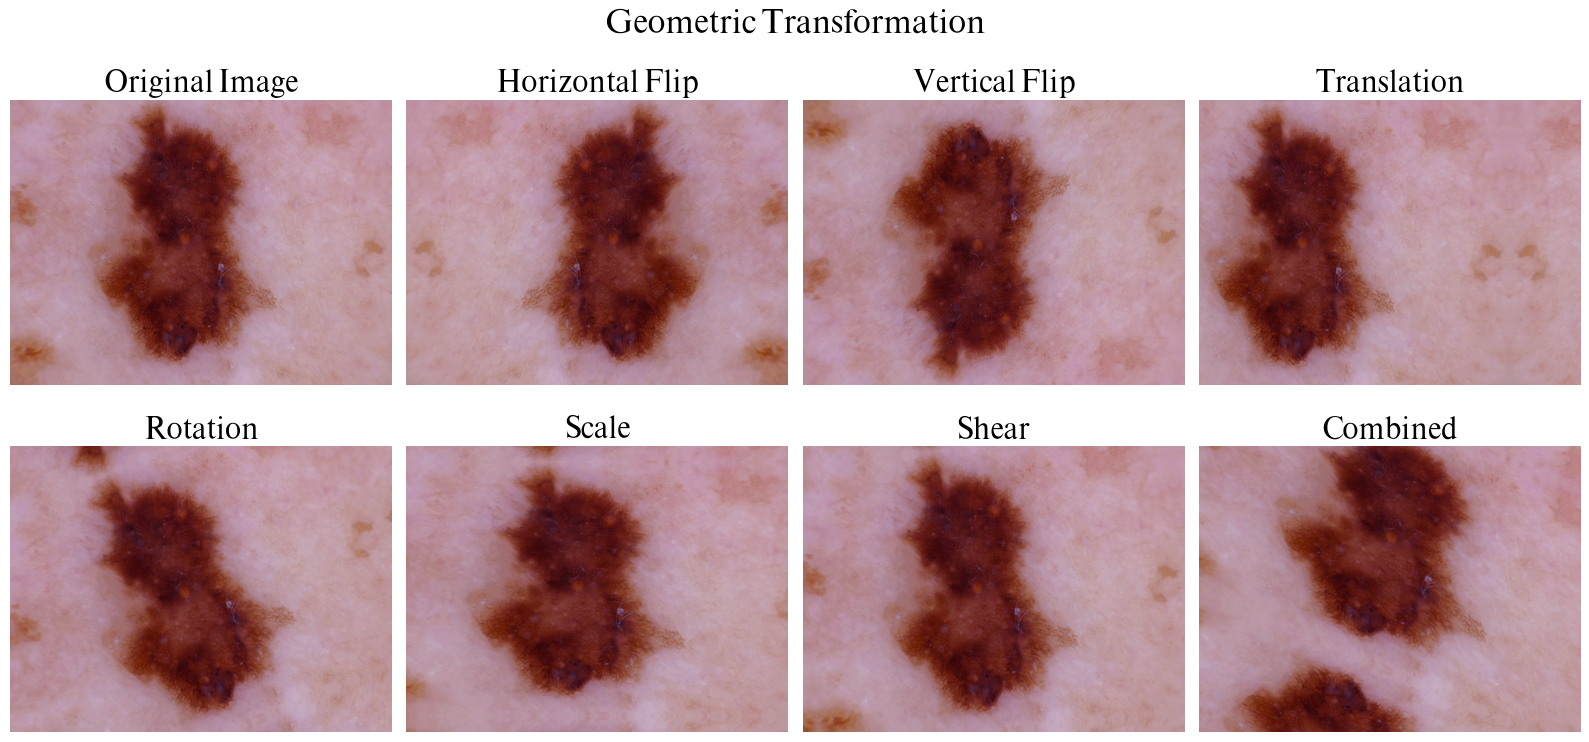

In [51]:
visualize_augmentation(
    df=df_train,
    filepaths_col="filepaths",
    transforms_sample=preview_transforms,
    title="Geometric Transformation",
    n_rows=2,
    n_cols=4,
    n_samples=1,
    seed=SEED,
    save_path=None,
    fontsize=20
)

In [52]:
merge_directory(
    df_train=df_train,
    df_val=df_val,
    df_test=df_test,
    filepaths_col="filepaths",
    labels_col="dx",
    dest_dir=OVER_DATASET_DIR,
    zip_dir=None
) # สำหรับ Oversamling Train

Destination directory has been created at: /content/ham10000DatasetOversampling

Processing train set (7832 images)...


Copying train: 100%|██████████| 7832/7832 [01:27<00:00, 89.90it/s]



Processing val set (984 images)...


Copying val: 100%|██████████| 984/984 [00:11<00:00, 83.28it/s]



Processing test set (955 images)...


Copying test: 100%|██████████| 955/955 [00:11<00:00, 80.40it/s]


In [53]:
df_train, df_val, df_test = update_path(
    df_train=df_train,
    df_val=df_val,
    df_test=df_test,
    base_path=OVER_DATASET_DIR,
    filepaths_col="filepaths",
    labels_col="dx"
) # Rename path to match new path

Updated paths for train (7832), val (984), test (955)


In [54]:
df_train_transform = apply_transform_to_target(
    df=df_train,
    filepaths_col="filepaths",
    labels_col="dx",
    transform=transform,
    base_dir=OVER_DATASET_DIR,
    zip_dir=OVER_DATASET_ZIP_PATH,
    max_target_ratio=0.5,
    max_aug_factor=4
)

Max class has 5211 images
Augmenting minority classes (up to ratio=0.5, max factor=4)

Skipping class 'nv' (5211 images)

Class 'mel': 879 → 2605 (need +1726 new images)


Augmenting mel: 100%|██████████| 1726/1726 [00:20<00:00, 83.51it/s] 



Class 'bkl': 861 → 2605 (need +1744 new images)


Augmenting bkl: 100%|██████████| 1744/1744 [00:21<00:00, 80.69it/s] 



Class 'bcc': 409 → 1636 (need +1227 new images)


Augmenting bcc: 100%|██████████| 1227/1227 [00:14<00:00, 85.80it/s] 



Class 'akiec': 264 → 1056 (need +792 new images)


Augmenting akiec: 100%|██████████| 792/792 [00:08<00:00, 97.54it/s]



Class 'vasc': 116 → 464 (need +348 new images)


Augmenting vasc: 100%|██████████| 348/348 [00:05<00:00, 69.54it/s]



Class 'df': 92 → 368 (need +276 new images)


Augmenting df: 100%|██████████| 276/276 [00:02<00:00, 95.14it/s] 


Zip file created containing 'ham10000DatasetOversampling' folder at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling.zip

Augmentation complete. New dataset size = 13945


In [56]:
df_train_transform.to_csv(f"{INDEX_PATH}/metadata_train.csv", index=False)
df_val.to_csv(f"{INDEX_PATH}/metadata_val.csv", index=False)
df_test.to_csv(f"{INDEX_PATH}/metadata_test.csv", index=False)

## **Section 8: Preparation Summary**

In [55]:
labels = process_df["dx"].unique().tolist()

total_count = []
train_count = []
aug_count = []
valid_count = []
test_count = []

for label in labels:
    total_count.append(process_df[process_df["dx"] == label].shape[0])
    train_count.append(df_train[df_train["dx"] == label].shape[0])
    aug_count.append(df_train_transform[df_train_transform["dx"] == label].shape[0])
    valid_count.append(df_val[df_val["dx"] == label].shape[0])
    test_count.append(df_test[df_test["dx"] == label].shape[0])

summary_df = pd.DataFrame({
    "Label": labels,
    "Total (100%)": total_count,
    "Train (80.16%)": train_count,
    "Augmented": aug_count,
    "Valid (10.07%)": valid_count,
    "Test (9.77%)": test_count
})
summary_df.to_csv(f"{INDEX_PATH}/dataset_description.csv", index=False)

print("Dataset overall description")
print("=======================================================================================================")
print(summary_df.to_string(index=False))
print("=======================================================================================================")
print(f"Training total count: {sum(train_count)}")
print(f"Augmented total count: {sum(aug_count)}")
print(f"Validation total count: {sum(valid_count)}")
print(f"Testing total count: {sum(test_count)}")

Dataset overall description
Label  Total (100%)  Train (80.16%)  Augmented  Valid (10.07%)  Test (9.77%)
  bkl          1076             861       2605             117            98
   nv          6499            5211       5211             651           637
   df           115              92        368              12            11
  mel          1103             879       2605             107           117
 vasc           142             116        464              15            11
  bcc           509             409       1636              52            48
akiec           327             264       1056              30            33
Training total count: 7832
Augmented total count: 13945
Validation total count: 984
Testing total count: 955


## **Section 9: Preprocess Metadata**

In [106]:
df_train = pd.read_csv(f"{INDEX_PATH}/metadata_train.csv")
df_val = pd.read_csv(f"{INDEX_PATH}/metadata_val.csv")
df_test = pd.read_csv(f"{INDEX_PATH}/metadata_test.csv")

print(f"Train shape: {df_train.shape}")
print(f"Validation shape:   {df_val.shape}")
print(f"Test shape:  {df_test.shape}")

Train shape: (13945, 10)
Validation shape:   (984, 10)
Test shape:  (955, 10)


In [107]:
numeric_cols = ["age"]
categorical_cols = ["sex", "localization"] # ไม่รวม Target
target_col = "cell_type_idx"
filepath_col = "filepaths"

### **For tab transformer**

In [108]:
numeric_transformer = sklearn.pipeline.Pipeline(steps=[
    ("imputer", sklearn.impute.SimpleImputer(strategy="median")),
    ("scaler", sklearn.preprocessing.StandardScaler())
])

categorical_transformer = sklearn.pipeline.Pipeline(steps=[
    ("imputer", sklearn.impute.SimpleImputer(strategy="most_frequent")),
    ("ordinal", sklearn.preprocessing.OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

In [109]:
transformer_preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_cols),
        ("categorical", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

print("Fitting preprocessor (for TabTransformer)...")
transformer_preprocessor.fit(df_train)

Fitting preprocessor (for TabTransformer)...


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['sex', 'localization'])])

In [110]:
joblib.dump(transformer_preprocessor, f"{INDEX_PATH}/tab_transformer_preprocess.joblib")
print("Preprocessors saved!")

Preprocessors saved!


### **For multi-layers perceptron**

In [112]:
numeric_mlp = sklearn.pipeline.Pipeline(steps=[
    ("imputer", sklearn.impute.SimpleImputer(strategy="median")),
    ("scaler", sklearn.preprocessing.StandardScaler())
])

categorical_mlp = sklearn.pipeline.Pipeline(steps=[
    ("imputer", sklearn.impute.SimpleImputer(strategy="most_frequent")),
    ("onehot", sklearn.preprocessing.OneHotEncoder(
        handle_unknown="ignore"
    ))
])

In [113]:
mlp_preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("numeric", numeric_mlp, numeric_cols),
        ("categorical", categorical_mlp, categorical_cols)
    ],
    remainder="drop"
)

print("Fitting preprocessor (for MLP)...")
mlp_preprocessor.fit(df_train)

Fitting preprocessor (for MLP)...


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'localization'])])

In [114]:
joblib.dump(mlp_preprocessor, f"{INDEX_PATH}/mlp_preprocess.joblib")
print("Preprocessors saved!")

Preprocessors saved!
